In [1]:
import patsy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime

from scipy.stats import ks_2samp
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier


In [2]:
df = pd.read_csv('data/credit_scoring.csv', parse_dates = ['data_ref'])

df['tempo_emprego'].fillna(-1, inplace=True)
df.head()

,data_ref,id_cliente,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,1,F,True,True,0,Assalariado,Secundário,Casado,Casa,49,8.605479,2.0,1916.54,0
1,2015-01-01,2,M,True,False,0,Empresário,Secundário,União,Casa,60,6.953425,2.0,2967.25,0
2,2015-01-01,3,F,True,False,0,Empresário,Secundário,Casado,Casa,28,0.682192,2.0,340.96,0
3,2015-01-01,4,F,False,True,0,Assalariado,Superior completo,Casado,Casa,60,1.879452,2.0,4903.16,0
4,2015-01-01,5,F,False,False,0,Empresário,Secundário,Casado,Casa,47,8.438356,2.0,3012.60,0


#### Bases de desenvolvimento, validação e *out-of-time*

Vamos separar as bases que utilizaremos para desenvolver o modelo (train), *tunar* o modelo (test) e avaliar a performance (val).

In [3]:
# Selecionar meses de 2016 para validação
df_val = df[df['data_ref'] >= datetime(2016,1,1)].copy()

# Selecionar meses de 2015 para treinamento e teste
df = df[df['data_ref'] < datetime(2016,1,1)]

df_train, df_test = train_test_split(df, test_size=0.3, random_state=12)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

print('Quantidade de linhas no treino:    ',df_train.shape[0])
print('Quantidade de linhas no teste:     ',df_test.shape[0])
print('Quantidade de linhas na validação: ',df_val.shape[0])

Quantidade de linhas no treino:     42000
Quantidade de linhas no teste:      18000
Quantidade de linhas na validação:  15000


In [4]:
equacao = '''mau ~ sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + educacao 
            + estado_civil + tipo_residencia + idade + qt_pessoas_residencia'''
           
y_train, X_train = patsy.dmatrices(equacao, data=df_train)
y_test, X_test = patsy.dmatrices(equacao, data=df_test)
y_val, X_val = patsy.dmatrices(equacao, data=df_val)


## Métricas para problemas de classificação

Vamos avaliar o desempenho do random forest nas base de treinamento, teste e validação. Vamos avaliar a partir das seguintes métricas KS, Gini, AUC e Acurácia.

#### Função para calcular o desempenho

Para facilitar essas comparações, vamos construir uma função para calcular todos esses indicadores. É interessante colocar valores padrão para os parâmetros da função, assim, vamos poder indicar somente a base de dados para rodar a função com os valores padrão dela.

In [17]:
def calcula_gini_auc(RESP, PD):
    #AUC
    auc = roc_auc_score(RESP, PD)
    
    #Gini
    gini = 2*auc -1
    return gini, auc


def print_metricas(dados, 
                  PD = 'PD', 
                  CLASSE_PRED = 'classe_predita', 
                  RESP = 'mau'):
    
    #Acuracia
    acc = accuracy_score(dados[RESP], dados[CLASSE_PRED])

    #AUC
    gini, auc = calcula_gini_auc(dados[RESP], dados[PD])
    
    #KS
    ks = ks_2samp(dados.loc[dados[RESP] == 1, PD], 
                  dados.loc[dados[RESP] != 1, PD]).statistic

    print('KS:       {0:.2f}%'.format(ks*100))
    print('AUC:      {0:.2f}%'.format(auc*100))
    print('GINI:     {0:.2f}%'.format(gini*100))
    print('Acurácia: {0:.2f}%\n'.format(acc*100))
    
    return None

## Random Forest no scikitlearn

In [18]:
%%time

clf = RandomForestClassifier(n_estimators=600, 
                             max_depth=13,
                             min_samples_leaf=41)

clf.fit(X_train,y_train.ravel())

df_train['classe_predita'] = clf.predict(X_train)
df_train['PD'] = clf.predict_proba(X_train)[:,1]

df_test['classe_predita'] = clf.predict(X_test)
df_test['PD'] = clf.predict_proba(X_test)[:,1]

df_val['classe_predita'] = clf.predict(X_val)
df_val['PD'] = clf.predict_proba(X_val)[:,1]

print('Train')
print_metricas(dados = df_train)
print('Test')
print_metricas(dados = df_test)
print('Val')
print_metricas(dados = df_val)

Train
KS:       21.96%
AUC:      65.60%
GINI:     31.21%
Acurácia: 93.03%

Test
KS:       15.81%
AUC:      60.41%
GINI:     20.83%
Acurácia: 93.16%

Val
KS:       16.31%
AUC:      60.44%
GINI:     20.87%
Acurácia: 92.88%

CPU times: user 13.5 s, sys: 183 ms, total: 13.7 s
Wall time: 13.7 s


# 2. Hiperparâmetros

Hiperparâmetros são parâmetros que controlam como o algoritmo é otimizado. O número de árvores por exemplo é um hiperparâmetro da *random forest*.

Qual é o melhor conjunto de hiperparâmetros para o *random forest*? Esta é a pergunta de ouro :) Mas felizmente há um método estruturado para se buscar esses hiperparâmetros, esse método é conhecido como *grid search* (ou busca em grade).

Vamos exemplificar essa busca de modo simplificado abaixo, buscando parâmetros um a um, em seguida variando mais de um ao longo de uma *grade* como o nome do método sugere.

## Gridsearch 1 - variando o número de árvores

Vamos estabelecer parâmetros fixos de ```max_depth``` e ```min_samples_leaf```, e variar o número de árvores, e avaliar a cada rodada o desempenho do modelo.

In [19]:
grid = list(range(100, 1001, 150))
grid

[100, 250, 400, 550, 700, 850, 1000]

In [20]:
for num_arvores in grid:
    print(num_arvores)

100
250
400
550
700
850
1000


In [21]:
def calcula_gini(RESP, PD):
    #AUC
    auc = roc_auc_score(RESP, PD)
    
    #Gini
    gini = 2*auc -1
    return gini

In [22]:
%%time
lista_gini_test=[]
lista_gini_train=[]

grid = list(range(100, 1001, 150))

for num_arvores in grid:
    clf = RandomForestClassifier(n_estimators=num_arvores,
                                 max_depth=10,
                                 min_samples_leaf=5)
    
    clf.fit(X_train,y_train.ravel())
    
    gini_test  = calcula_gini(y_test, clf.predict_proba(X_test)[:,1])
    gini_train = calcula_gini(y_train, clf.predict_proba(X_train)[:,1])
    
    lista_gini_test.append(gini_test)
    lista_gini_train.append(gini_train)


CPU times: user 59 s, sys: 941 ms, total: 59.9 s
Wall time: 60 s


In [26]:
zip_gini_train = zip(list(range(100, 1001, 150)), lista_gini_train)
zip_gini_test = zip(list(range(100, 1001, 150)), lista_gini_test)

dict_gini_train = dict(zip_gini_train)
dict_gini_test = dict(zip_gini_test)


series_gini_train = pd.Series(dict_gini_train)
series_gini_test = pd.Series(dict_gini_test)
print(f"Train\n{series_gini_train}\n\n")
print(f"Test\n{series_gini_test}")

Train
100     0.356340
250     0.361507
400     0.360794
550     0.360238
700     0.361359
850     0.361152
1000    0.361636
dtype: float64


Test
100     0.204255
250     0.208051
400     0.204850
550     0.207373
700     0.206766
850     0.207260
1000    0.206888
dtype: float64


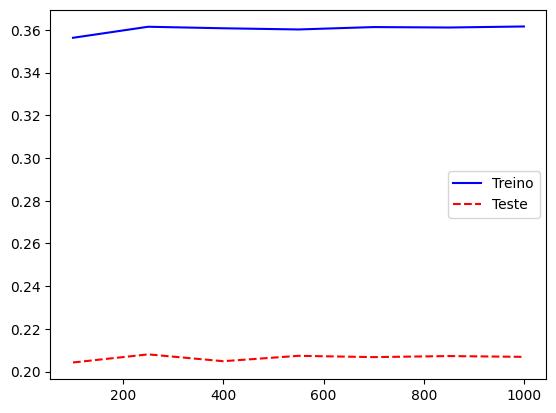

In [27]:
#Plot comparando o gini no treino e no teste
fig, ax = plt.subplots()

ax.plot(series_gini_train, '-b', label='Treino')
ax.plot(series_gini_test,  '--r', label='Teste')

leg = ax.legend()


In [28]:
grid = list(range(1, 1000, 20))
print(grid)

[1, 21, 41, 61, 81, 101, 121, 141, 161, 181, 201, 221, 241, 261, 281, 301, 321, 341, 361, 381, 401, 421, 441, 461, 481, 501, 521, 541, 561, 581, 601, 621, 641, 661, 681, 701, 721, 741, 761, 781, 801, 821, 841, 861, 881, 901, 921, 941, 961, 981]


In [29]:
len(grid)

50

In [30]:
%%time

lista_gini_test=[]
lista_gini_train=[]

grid = list(range(1, 1000, 20))
print(grid)

for num_arvores in grid:
    clf = RandomForestClassifier(n_estimators=num_arvores,
                                 max_depth=10,
                                 min_samples_leaf=5,
                                 n_jobs=-1)
    
    clf.fit(X_train, y_train.ravel())
    
    gini_test  = calcula_gini(y_test, clf.predict_proba(X_test)[:,1])
    gini_train = calcula_gini(y_train, clf.predict_proba(X_train)[:,1])
    
    lista_gini_test.append(gini_test)
    lista_gini_train.append(gini_train)

[1, 21, 41, 61, 81, 101, 121, 141, 161, 181, 201, 221, 241, 261, 281, 301, 321, 341, 361, 381, 401, 421, 441, 461, 481, 501, 521, 541, 561, 581, 601, 621, 641, 661, 681, 701, 721, 741, 761, 781, 801, 821, 841, 861, 881, 901, 921, 941, 961, 981]
CPU times: user 6min 46s, sys: 26.1 s, total: 7min 12s
Wall time: 1min 30s


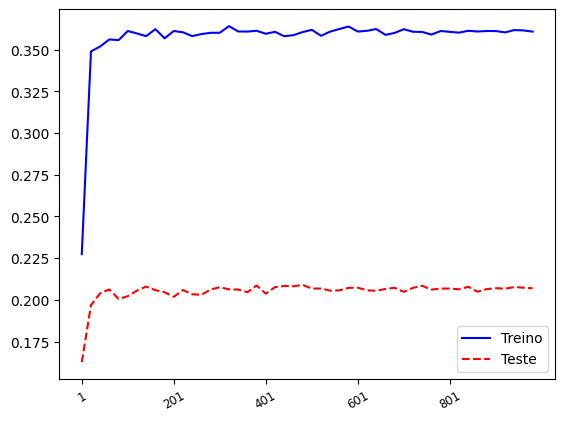

In [32]:
fig, ax = plt.subplots()
ax.plot(lista_gini_train, '-b', label='Treino')
ax.plot(lista_gini_test, '--r', label='Teste')

leg = ax.legend()
ticks = ax.set_xticks(range(0, len(grid), 10))
labels = ax.set_xticklabels(labels=grid[::10], rotation=30, fontsize='small');

## Função GridSearchCV

In [41]:
list(range(1, 50, 5))

[1, 6, 11, 16, 21, 26, 31, 36, 41, 46]

In [39]:
from sklearn.model_selection import GridSearchCV


In [45]:
%%time
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier()

params = {
    'max_depth' : [10],
    'min_samples_leaf': [5],
    'n_estimators': list(range(20, 500, 50))
}

grid_rf = GridSearchCV(estimator = rf,
                        param_grid = params,
                        scoring = 'accuracy', 
                        cv = 5,
                        verbose=5)

grid_rf.fit(X_train, y_train.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END max_depth=10, min_samples_leaf=5, n_estimators=20;, score=0.930 total time=   0.2s
[CV 2/5] END max_depth=10, min_samples_leaf=5, n_estimators=20;, score=0.930 total time=   0.2s
[CV 3/5] END max_depth=10, min_samples_leaf=5, n_estimators=20;, score=0.930 total time=   0.2s
[CV 4/5] END max_depth=10, min_samples_leaf=5, n_estimators=20;, score=0.930 total time=   0.2s
[CV 5/5] END max_depth=10, min_samples_leaf=5, n_estimators=20;, score=0.930 total time=   0.2s
[CV 1/5] END max_depth=10, min_samples_leaf=5, n_estimators=70;, score=0.930 total time=   0.7s
[CV 2/5] END max_depth=10, min_samples_leaf=5, n_estimators=70;, score=0.930 total time=   0.7s
[CV 3/5] END max_depth=10, min_samples_leaf=5, n_estimators=70;, score=0.930 total time=   0.7s
[CV 4/5] END max_depth=10, min_samples_leaf=5, n_estimators=70;, score=0.930 total time=   0.7s
[CV 5/5] END max_depth=10, min_samples_leaf=5, n_estimators=70;, score=0.93

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [10], 'min_samples_leaf': [5],
                         'n_estimators': [20, 70, 120, 170, 220, 270, 320, 370,
                                          420, 470]},
             scoring='accuracy', verbose=5)

In [46]:
grid_rf.cv_results_

{'mean_fit_time': array([0.19037552, 0.64883623, 1.1082551 , 1.58679523, 2.05379496,
        2.5204411 , 2.97962437, 3.46774082, 3.881811  , 4.35381093]),
 'std_fit_time': array([0.00205875, 0.00762642, 0.01001651, 0.01497941, 0.0343558 ,
        0.02650527, 0.02877748, 0.05807727, 0.02166031, 0.0248327 ]),
 'mean_score_time': array([0.01507664, 0.04762983, 0.0780334 , 0.11279902, 0.14891968,
        0.17800822, 0.21004062, 0.24843068, 0.27079844, 0.3065135 ]),
 'std_score_time': array([0.00126606, 0.00262152, 0.00129993, 0.00345036, 0.0084777 ,
        0.00274958, 0.00439343, 0.00759248, 0.00177963, 0.00347197]),
 'param_max_depth': masked_array(data=[10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_leaf': masked_array(data=[5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
              mask=[False, False, False, False, False, Fal

In [47]:
grid_rf.cv_results_['params']

[{'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 20},
 {'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 70},
 {'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 120},
 {'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 170},
 {'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 220},
 {'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 270},
 {'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 320},
 {'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 370},
 {'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 420},
 {'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 470}]

In [48]:
print(grid_rf.best_estimator_)


RandomForestClassifier(max_depth=10, min_samples_leaf=5, n_estimators=20)


In [49]:
# print os melhores parametros
print(grid_rf.best_estimator_)

# 
print(grid_rf.best_estimator_.score(X_test, y_test))
print(grid_rf.score(X_test, y_test))



RandomForestClassifier(max_depth=10, min_samples_leaf=5, n_estimators=20)
0.9316111111111111
0.9316111111111111


## Randomizedsearch 2 - Variando mínimo de observações por folha

Agora vamos variar apenas ```min_samples_leaf```.

In [54]:
%%time
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestClassifier()

params = {
    'max_depth' : [10],
    'min_samples_leaf': list(range(2,5000,100)),
    'n_estimators': [800]
}

grid_rf = RandomizedSearchCV(n_iter = 5,
                             estimator = rf,
                             param_distributions = params,
                             scoring = 'accuracy', 
                             cv = 3,
                             verbose=5)

grid_rf.fit(X_train, y_train.ravel())

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3] END max_depth=10, min_samples_leaf=602, n_estimators=800;, score=0.930 total time=   4.6s
[CV 2/3] END max_depth=10, min_samples_leaf=602, n_estimators=800;, score=0.930 total time=   4.5s
[CV 3/3] END max_depth=10, min_samples_leaf=602, n_estimators=800;, score=0.930 total time=   4.7s
[CV 1/3] END max_depth=10, min_samples_leaf=1702, n_estimators=800;, score=0.930 total time=   3.6s
[CV 2/3] END max_depth=10, min_samples_leaf=1702, n_estimators=800;, score=0.930 total time=   3.7s
[CV 3/3] END max_depth=10, min_samples_leaf=1702, n_estimators=800;, score=0.930 total time=   3.7s
[CV 1/3] END max_depth=10, min_samples_leaf=3602, n_estimators=800;, score=0.930 total time=   3.1s
[CV 2/3] END max_depth=10, min_samples_leaf=3602, n_estimators=800;, score=0.930 total time=   3.1s
[CV 3/3] END max_depth=10, min_samples_leaf=3602, n_estimators=800;, score=0.930 total time=   3.1s
[CV 1/3] END max_depth=10, min_samples_leaf

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': [10],
                                        'min_samples_leaf': [2, 102, 202, 302,
                                                             402, 502, 602, 702,
                                                             802, 902, 1002,
                                                             1102, 1202, 1302,
                                                             1402, 1502, 1602,
                                                             1702, 1802, 1902,
                                                             2002, 2102, 2202,
                                                             2302, 2402, 2502,
                                                             2602, 2702, 2802,
                                                             2902, ...],
                                        'n_estimators': [800]},
                   scoring='accuracy', verbose=5)

In [55]:
grid_rf.cv_results_['params']

[{'n_estimators': 800, 'min_samples_leaf': 602, 'max_depth': 10},
 {'n_estimators': 800, 'min_samples_leaf': 1702, 'max_depth': 10},
 {'n_estimators': 800, 'min_samples_leaf': 3602, 'max_depth': 10},
 {'n_estimators': 800, 'min_samples_leaf': 2202, 'max_depth': 10},
 {'n_estimators': 800, 'min_samples_leaf': 3402, 'max_depth': 10}]

In [56]:
grid_rf.cv_results_['mean_test_score']

array([0.93030952, 0.93030952, 0.93030952, 0.93030952, 0.93030952])

In [57]:
print(grid_rf.score(X_test, y_test))


0.9316111111111111


## Função RandomizedSearchCV

In [58]:
params = {
    'max_depth' : [10],
    'min_samples_leaf': [5],
    'n_estimators': list(range(100, 1001, 100))
}
params

{'max_depth': [10],
 'min_samples_leaf': [5],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}

In [59]:
%%time
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestClassifier()

params = {
    'max_depth' : [10],
    'min_samples_leaf': [5],
    'n_estimators': list(range(100, 1001, 100))
}

grid_rf = RandomizedSearchCV(n_iter = 7,
                             estimator = rf,
                             param_distributions = params,
                             scoring = 'accuracy', 
                             cv = 3,
                             verbose=5)

grid_rf.fit(X_train, y_train.ravel())

Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV 1/3] END max_depth=10, min_samples_leaf=5, n_estimators=100;, score=0.930 total time=   0.9s
[CV 2/3] END max_depth=10, min_samples_leaf=5, n_estimators=100;, score=0.930 total time=   0.9s
[CV 3/3] END max_depth=10, min_samples_leaf=5, n_estimators=100;, score=0.930 total time=   0.9s
[CV 1/3] END max_depth=10, min_samples_leaf=5, n_estimators=800;, score=0.930 total time=   7.0s
[CV 2/3] END max_depth=10, min_samples_leaf=5, n_estimators=800;, score=0.930 total time=   7.2s
[CV 3/3] END max_depth=10, min_samples_leaf=5, n_estimators=800;, score=0.930 total time=   6.9s
[CV 1/3] END max_depth=10, min_samples_leaf=5, n_estimators=500;, score=0.930 total time=   4.3s
[CV 2/3] END max_depth=10, min_samples_leaf=5, n_estimators=500;, score=0.930 total time=   4.3s
[CV 3/3] END max_depth=10, min_samples_leaf=5, n_estimators=500;, score=0.930 total time=   4.4s
[CV 1/3] END max_depth=10, min_samples_leaf=5, n_estimators=200;, s

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=7,
                   param_distributions={'max_depth': [10],
                                        'min_samples_leaf': [5],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   scoring='accuracy', verbose=5)

In [60]:
# extract best estimator
print(grid_rf.best_estimator_)

# to test the bestfit
print(grid_rf.score(X_test, y_test))



RandomForestClassifier(max_depth=10, min_samples_leaf=5)
0.9316111111111111


## Gridsearch usando `for` para variar o número mínimo de observações na folha

In [61]:
%%time

lista_gini_test=[]
lista_gini_train=[]

grid = list(range(2,5000,100))
print(grid)

for n_min_obs in grid:
    clf = RandomForestClassifier(n_estimators=30,
                                 max_depth=10,
                                 min_samples_leaf=n_min_obs,
                                 n_jobs=-1)
    
    clf.fit(X_train, y_train.ravel())
    
    gini_test  = calcula_gini(y_test, clf.predict_proba(X_test)[:,1])
    gini_train = calcula_gini(y_train, clf.predict_proba(X_train)[:,1])
    
    lista_gini_test.append(gini_test)
    lista_gini_train.append(gini_train)

dict_gini_train = dict(zip(list(range(2,5000,100)), lista_gini_train))
dict_gini_test = dict(zip(list(range(2,5000,100)), lista_gini_test))

series_gini_train = pd.Series(dict_gini_train)
series_gini_test = pd.Series(dict_gini_test)


[2, 102, 202, 302, 402, 502, 602, 702, 802, 902, 1002, 1102, 1202, 1302, 1402, 1502, 1602, 1702, 1802, 1902, 2002, 2102, 2202, 2302, 2402, 2502, 2602, 2702, 2802, 2902, 3002, 3102, 3202, 3302, 3402, 3502, 3602, 3702, 3802, 3902, 4002, 4102, 4202, 4302, 4402, 4502, 4602, 4702, 4802, 4902]
CPU times: user 15.4 s, sys: 1.8 s, total: 17.2 s
Wall time: 5.51 s


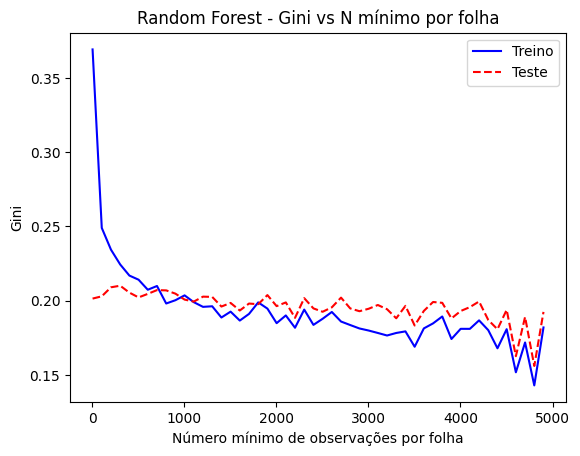

In [62]:
#Plot comparando o gini no treino e no teste
fig, ax = plt.subplots()

ax.plot(series_gini_train, '-b', label='Treino')
ax.plot(series_gini_test,  '--r', label='Teste')

leg = ax.legend()
ax.set_title("Random Forest - Gini vs N mínimo por folha")
ax.set_xlabel("Número mínimo de observações por folha")
ax.set_ylabel("Gini");

## Gridsearch 3 (usando `for`)  - variando a profundidade da árvore

Agora vamos fixar ```n_estimators``` e ```min_samples_leaf``` e variar ```max_depth```.

In [63]:
%%time

lista_gini_test=[]
lista_gini_train=[]

grid = list(range(1,50))
print(grid)

for profundidade in grid:
    clf = RandomForestClassifier(n_estimators=30,
                                 max_depth=profundidade,
                                 min_samples_leaf=1,
                                n_jobs=-1)
    
    clf.fit(X_train, y_train.ravel())
    
    gini_test  = calcula_gini(y_test, clf.predict_proba(X_test)[:,1])
    gini_train = calcula_gini(y_train, clf.predict_proba(X_train)[:,1])
    
    lista_gini_test.append(gini_test)
    lista_gini_train.append(gini_train)

dict_gini_train = dict(zip(grid, lista_gini_train))
dict_gini_test = dict(zip(grid, lista_gini_test))

series_gini_train = pd.Series(dict_gini_train)
series_gini_test = pd.Series(dict_gini_test)


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
CPU times: user 36 s, sys: 1.62 s, total: 37.6 s
Wall time: 8 s


Text(0, 0.5, 'Gini')

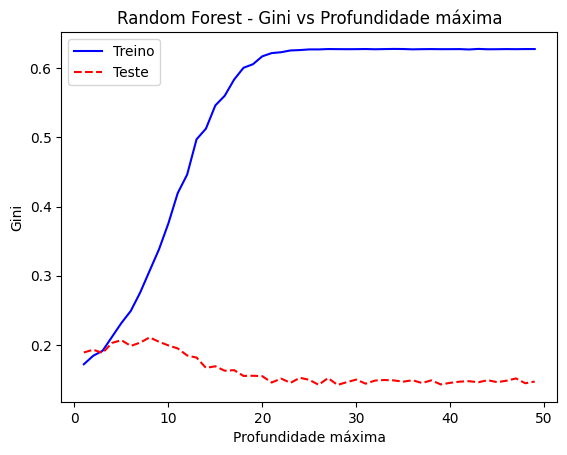

In [64]:
#Plot comparando o gini no treino e no teste
fig, ax = plt.subplots()

ax.plot(series_gini_train, '-b', label='Treino')
ax.plot(series_gini_test,  '--r', label='Teste')

leg = ax.legend()
ax.set_title("Random Forest - Gini vs Profundidade máxima")
ax.set_xlabel("Profundidade máxima")
ax.set_ylabel("Gini")

## Gridsearch 4 - alterar profundidade e número de observações por folha

In [65]:
%%time

lista_gini_test = []
lista_gini_train = []
lista_obs_folha = []
lista_profundidade = []

grid_profund = list(range(3, 20, 2))
grid_obs_folha = list(range(1, 30, 1))

for profundidade in grid_profund:
    for obs_folha in grid_obs_folha:
        clf = RandomForestClassifier(n_estimators=30,
                                     max_depth=profundidade,
                                     min_samples_leaf=obs_folha,
                                     n_jobs=-1)

        clf.fit(X_train, y_train.ravel())

        gini_test = calcula_gini(y_test, clf.predict_proba(X_test)[:, 1])
        gini_train = calcula_gini(y_train, clf.predict_proba(X_train)[:, 1])

        lista_gini_test.append(gini_test)
        lista_gini_train.append(gini_train)
        lista_obs_folha.append(obs_folha)
        lista_profundidade.append(profundidade)

grid_dic = {'obs_folha': lista_obs_folha, 
            'profund_max': lista_profundidade,
            'gini_dev': lista_gini_train,
            'gini_test': lista_gini_test}

grid = pd.DataFrame(grid_dic)

CPU times: user 2min 10s, sys: 8.83 s, total: 2min 19s
Wall time: 35.5 s


In [66]:
grid

,obs_folha,profund_max,gini_dev,gini_test
0,1,3,0.196907,0.196675
1,2,3,0.189810,0.191872
2,3,3,0.191211,0.195783
3,4,3,0.198229,0.196487
4,5,3,0.198810,0.196711
...,...,...,...,...
256,25,19,0.374773,0.198726
257,26,19,0.364212,0.204199
258,27,19,0.360367,0.206233
259,28,19,0.356796,0.202069


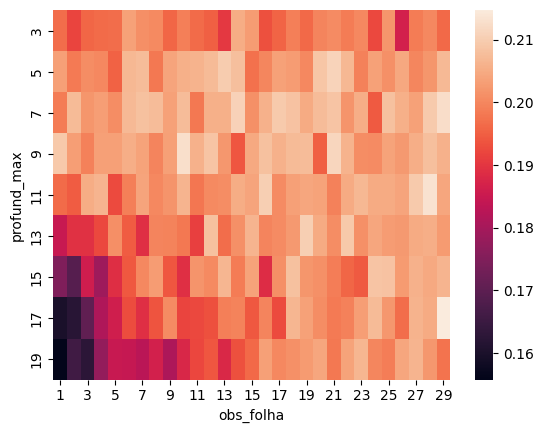

In [67]:
sns.heatmap(grid.pivot_table(index='profund_max',
                             columns='obs_folha',
                             values='gini_test',
                             aggfunc='mean'));

In [70]:
grid[(grid['obs_folha'] == 29) & (grid['profund_max'] == 17)]

,obs_folha,profund_max,gini_dev,gini_test
231,29,17,0.352547,0.214722


In [71]:
grid['gini_test'].max()

0.21472181924026268